In [703]:
import numpy as np
import seaborn as sns
import re
import pandas as pd
import os

Here is the post-processing notebook. As of writing this, the code only exports a txt file "highestXPos.txt". The file contains the highestXPos at each frame, with each line in the text file being a single frame. This notebook serves as a "sketchbook" for post-processing, before it is written in the napari plugin.

Ideas:
- ~~Trim the data after towards the end (after smoothing, etc.)~~ I want to benchmark the average speed at each step so I have to do this step first now
- Variable names will be like the steps taken (e.g. smoothed twice = "dataSmoothSmooth", smoothed then cropped = "dataSmoothCrop")

In [704]:
dataFolder = "/Users/kyle/Desktop/ros_benchmark/DSC_0201_Test_No_250"
thermoCoupleDataFolder = "/Users/kyle/Library/CloudStorage/Box-Box/ROS_Experiments_Data_Folder/CSV file data"

# Import highestXPos.txt and preview it
data = np.loadtxt(dataFolder + "/highestXPos.txt")

In [705]:
# Extract test string from filename
# Use regex to extract, e.g. "Test_No_250" from "DSC_0201_Test_No_250"
testString = re.search(r"Test_No_\d+", dataFolder).group(0)
print(testString)

# Get thermocouple data
# thermocouple_location(cm),Ignition_time(sec),Middle_points(cm),ROS(cm/sec)
thermoCoupleData = pd.read_csv(
    os.path.join(thermoCoupleDataFolder, f"{testString}_ROS_output.csv")
)

Test_No_250


<Axes: >

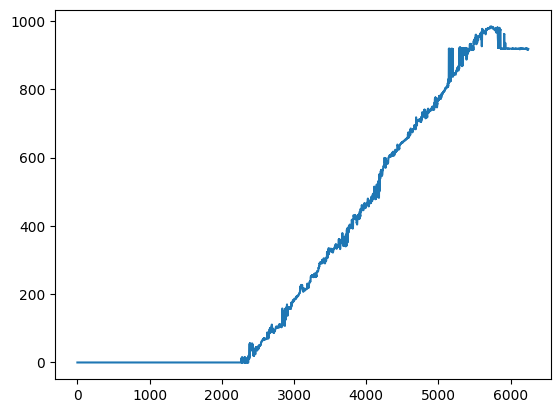

In [706]:
# Plot data
sns.lineplot(data=data)

In [707]:
# Get the max index
maxIndex = data.argmax()

# Get the first index where there is a value above zero
firstIndex = np.where(data > 0)[0][0]

# TODO: Make sure to check weird edge cases
dataTrim = data[firstIndex:maxIndex]

<Axes: >

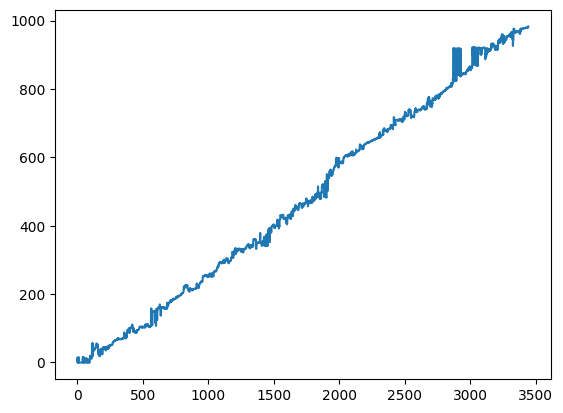

In [708]:
# Plot dataTrim
sns.lineplot(data=dataTrim)

<Axes: >

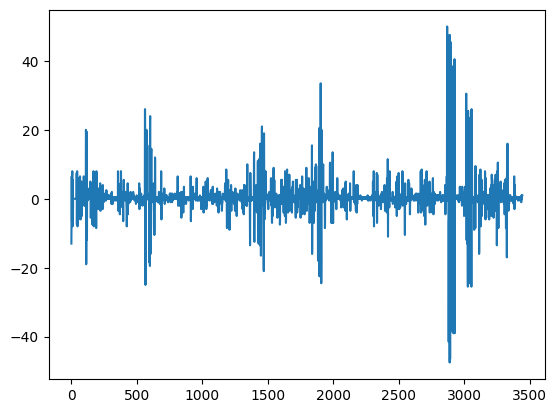

In [709]:
# Get the gradient
dataTrimGradient = np.gradient(dataTrim)

# Plot dataTrimGradient
sns.lineplot(data=dataTrimGradient)

In [710]:
# Get the average speed
dataTrimGradientAvgSpeed = np.average(dataTrimGradient)
print(dataTrimGradientAvgSpeed)

0.2797446314567615


In [711]:
# Smooth data with moving average
# (what MATLAB's smoothdata() does)
# TODO: I don't know the window matlab uses
window = 100
dataTrimSmooth = np.convolve(dataTrim, np.ones(window), 'valid') / window

<Axes: >

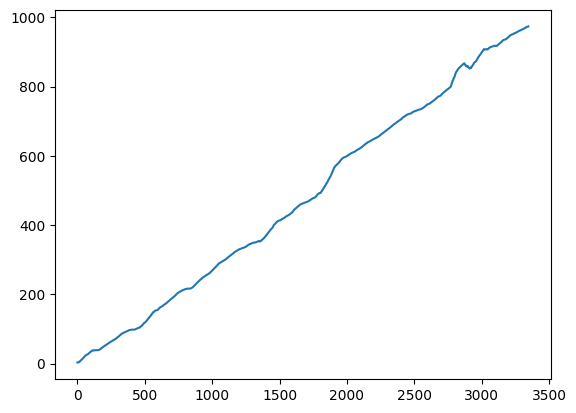

In [712]:
# Plot smoothed data
sns.lineplot(data=dataTrimSmooth)

<Axes: >

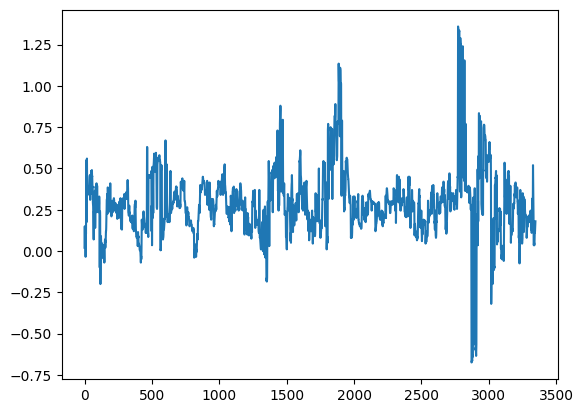

In [713]:
# Get the gradient
dataTrimSmoothGradient = np.gradient(dataTrimSmooth)

# Plot dataTrimSmoothGradient
sns.lineplot(data=dataTrimSmoothGradient)

In [714]:
# Get the average speed
dataTrimSmoothGradientAvgSpeed = np.average(dataTrimSmoothGradient)
print(dataTrimSmoothGradientAvgSpeed)

0.2898237227367792


In [715]:
print("Without smoothing:", dataTrimGradientAvgSpeed)
print("   With smoothing:", dataTrimSmoothGradientAvgSpeed)
print("")
print("Difference:", dataTrimSmoothGradientAvgSpeed - dataTrimGradientAvgSpeed)

Without smoothing: 0.2797446314567615
   With smoothing: 0.2898237227367792

Difference: 0.010079091280017716


# Plot against thermocouple data

In [716]:
# Create pd dataframe from dataTrim, frame number vs. highestXPos.
# Create frame numbers list from dataTrim.
lengthOfDataset = len(dataTrimSmooth)
frameNumbers = np.arange(0, lengthOfDataset)

# TODO: Why does dataTrimSmooth have less length?
dataTrimPd = pd.DataFrame({"frame": frameNumbers, "highestXPos": dataTrim[:lengthOfDataset], "highestXPosSmooth": dataTrimSmooth})
dataTrimPd.head()

,frame,highestXPos,highestXPosSmooth
0,0,13.0,3.43
1,1,0.0,3.45
2,2,0.0,3.60
3,3,13.0,3.75
4,4,13.0,3.78


In [717]:
# Convert frame column to seconds. The videos are 59.94 fps.
dataTrimPd = dataTrimPd.assign(
    seconds=lambda x: x.frame / 59.94
)
dataTrimPd.head()

,frame,highestXPos,highestXPosSmooth,seconds
0,0,13.0,3.43,0.000000
1,1,0.0,3.45,0.016683
2,2,0.0,3.60,0.033367
3,3,13.0,3.75,0.050050
4,4,13.0,3.78,0.066733


In [718]:
# Convert pixels to cm
# Currently the highestXPos column is in pixels.

# 104 pixels = 4.5cm
pixelsInUnit = 104
unitCm = 4.5

dataTrimPd = dataTrimPd.assign(
    highestXPosCm=lambda x: x.highestXPos / pixelsInUnit * unitCm
)
dataTrimPd = dataTrimPd.assign(
    highestXPosSmoothCm = lambda x: x.highestXPosSmooth / pixelsInUnit * unitCm
)
dataTrimPd.head()

,frame,highestXPos,highestXPosSmooth,seconds,highestXPosCm,highestXPosSmoothCm
0,0,13.0,3.43,0.000000,0.5625,0.148413
1,1,0.0,3.45,0.016683,0.0000,0.149279
2,2,0.0,3.60,0.033367,0.0000,0.155769
3,3,13.0,3.75,0.050050,0.5625,0.162260
4,4,13.0,3.78,0.066733,0.5625,0.163558


In [719]:
# Now join everything
# Round your time columns to the nearest tenth of seconds
dataTrimPd['seconds_rounded'] = dataTrimPd['seconds'].apply(lambda x: np.round(x * 10) / 10)
thermoCoupleData['Ignition_time_rounded'] = thermoCoupleData['Ignition_time(sec)'].apply(lambda x: np.round(x * 10) / 10)

# Merge the dataframes on the rounded time columns
merged_df = pd.merge(dataTrimPd, thermoCoupleData, left_on='seconds_rounded', right_on='Ignition_time_rounded', how='outer')

merged_df

,frame,highestXPos,highestXPosSmooth,seconds,highestXPosCm,highestXPosSmoothCm,seconds_rounded,thermocouple_location(cm),Ignition_time(sec),Middle_points(cm),ROS(cm/sec),Ignition_time_rounded
0,0,13.0,3.43,0.000000,0.562500,0.148413,0.0,0.0,0.0,6.75,0.87,0.0
1,1,0.0,3.45,0.016683,0.000000,0.149279,0.0,0.0,0.0,6.75,0.87,0.0
2,2,0.0,3.60,0.033367,0.000000,0.155769,0.0,0.0,0.0,6.75,0.87,0.0
3,3,13.0,3.75,0.050050,0.562500,0.162260,0.1,NaN,NaN,NaN,NaN,NaN
4,4,13.0,3.78,0.066733,0.562500,0.163558,0.1,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
3342,3342,969.0,972.80,55.755756,41.927885,42.092308,55.8,NaN,NaN,NaN,NaN,NaN
3343,3343,968.0,972.91,55.772439,41.884615,42.097067,55.8,NaN,NaN,NaN,NaN,NaN
3344,3344,967.0,973.04,55.789122,41.841346,42.102692,55.8,NaN,NaN,NaN,NaN,NaN
3345,3345,965.0,973.19,55.805806,41.754808,42.109183,55.8,NaN,NaN,NaN,NaN,NaN


Text(0.5, 1.0, 'Test_No_250 -- 104px per 4.5cm')

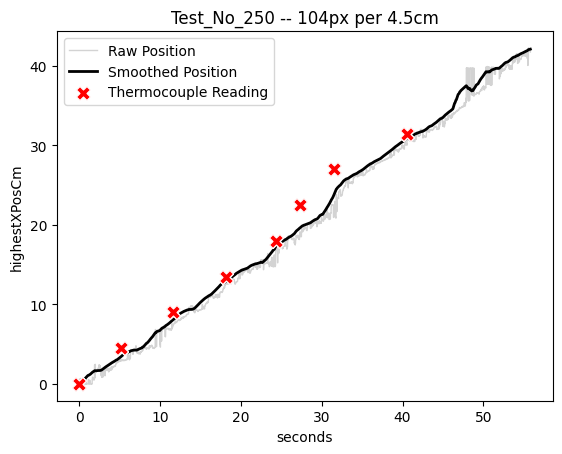

In [720]:
comparison = sns.lineplot(merged_df, x="seconds", y="highestXPosCm", color="lightgrey", linewidth=1, label="Raw Position")
comparison = sns.lineplot(merged_df, x="seconds", y="highestXPosSmoothCm", color="black", linewidth=2, label="Smoothed Position")
comparison = sns.scatterplot(merged_df, x="Ignition_time(sec)", y="thermocouple_location(cm)", color="red", marker="X", s=100, zorder=10, label="Thermocouple Reading")

comparison.set_title(f"{testString} -- {pixelsInUnit}px per {unitCm}cm")

In [721]:
folderToSave = f"/Users/kyle/Library/CloudStorage/Box-Box/ROS_Experiments_Data_Folder/results/{testString}"

# Make folder if it doesn't exist
if not os.path.exists(folderToSave):
    os.makedirs(folderToSave)

# Save plot to file
comparison.figure.savefig(f"{folderToSave}/plot.png")

# Simple version of merged_df
simple_merged_df = merged_df[["seconds", "highestXPosSmoothCm", "Ignition_time(sec)", "thermocouple_location(cm)",]]
# Rename columns
simple_merged_df.columns = ["video_seconds (sec)", "hsv_highestXPos_smooth (cm)", "thermocouple_Ignition_time (sec)", "thermocouple_location (cm)"]

# Save merged_df to CSV
simple_merged_df.to_csv(f"{folderToSave}/table.csv")